# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Friends Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Friends script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximally distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **300 lines** of each character in the training data `training.csv` to create the training documents and a maximum of the first **30 lines** in the validation and test data (from `val.csv` and `test.csv`). This makes it more challenging, as the number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [1]:
!pip install nltk

In [2]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict
from itertools import combinations
from string import punctuation

import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk
from nltk import ngrams
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [3]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data

,Episode,Scene,Character_name,Line,Gender
0,s01e01,c01,Monica Geller,There's nothing to tell! He's just some guy I work with!,Female
1,s01e01,c01,Joey Tribbiani,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",Male
2,s01e01,c01,Chandler Bing,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",Male
3,s01e01,c01,Phoebe Buffay,"Wait, does he eat chalk?",Female
4,s01e01,c01,Phoebe Buffay,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!",Female
...,...,...,...,...,...
53548,s03e25,c12,Ross Geller,Hi.,Male
53549,s03e25,c13,Chandler Bing,Hi there.,Male
53550,s03e25,c13,Monica Geller,That's that weird voice again.,Female
53551,s03e25,c13,Chandler Bing,"Okay! Okay! Let me try it again, you're gonna wanna date this next guy, I swear!",Male


In [4]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """
    Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them, along with the context of lines spoken in the same scene.

    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}

    # Iterate through each episode and scene
    for episode in df['Episode'].unique():
        for scene in df[df['Episode'] == episode]['Scene'].unique():
            scene_df = df[(df['Episode'] == episode) & (df['Scene'] == scene)]

            # Collect all dialogue in the scene
            scene_dialogue = scene_df['Line'].apply(str) + " _EOL_ "
            scene_dialogue = scene_dialogue.sum()

            for name in scene_df['Character_name'].unique():
                if name not in character_docs:
                    character_docs[name] = ""
                    character_line_count[name] = 0

                # Add dialogue to character document respecting the max_line_count
                if character_line_count[name] < max_line_count:
                    character_docs[name] += scene_dialogue
                    character_line_count[name] += scene_df[scene_df['Character_name'] == name].shape[0]

    print("lines per character", character_line_count)
    return character_docs

In [5]:
# print out the number of words each character has in the training set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'Monica Geller': 302, 'Joey Tribbiani': 304, 'Chandler Bing': 300, 'Phoebe Buffay': 302, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 302, 'Other_None': 309, 'Other_Female': 304, 'Other_Male': 303}
Num. Characters:  10 

Monica Geller Number of Words:  14216
Joey Tribbiani Number of Words:  21267
Chandler Bing Number of Words:  15890
Phoebe Buffay Number of Words:  20247
#ALL# Number of Words:  79611
Ross Geller Number of Words:  13211
Rachel Green Number of Words:  18366
Other_None Number of Words:  14995
Other_Female Number of Words:  12825
Other_Male Number of Words:  16806
total words 227434


In [6]:
pre_process_method = 0

def pre_process(character_text, method=0):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    if method == 0: # use default method
        tokens = character_text.split()   # just a simple tokenization, to be replaced
        return tokens
    
    methods = {
        1: pre_process_1,
        2: pre_process_2,
        3: pre_process_3,
        4: pre_process_4,
        5: pre_process_5,
    }

    return methods[method](character_text)

def pre_process_1(text, order=1):
    """
    Remove stopwords and punctuation.
    """
    banned = stopwords.words("english") + list(punctuation)
    
    tokens = text.split()
    tokens = [
        t for t in tokens 
        if t.lower() not in banned
    ]
    tokens = ['<s>'] * (order-1) + tokens + ['</s>']
    return tokens

def pre_process_2(text, order=1):
    """
    Take stem of words.
    """
    banned = stopwords.words("english") + list(punctuation)
    stemmer = PorterStemmer()

    tokens = text.split()
    tokens = [
        stemmer.stem(t) for t in tokens 
        if t.lower() not in banned
    ]
    tokens = ['<s>'] * (order-1) + tokens + ['</s>']
    return tokens
    

def pre_process_3(text, order=1):
    """
    Take lemma of words.
    """
    banned = stopwords.words("english") + list(punctuation)
    lemmatiser = WordNetLemmatizer()

    tokens = text.split()
    tokens = [
        lemmatiser.lemmatize(t) for t in tokens 
        if t.lower() not in banned
    ]
    tokens = ['<s>'] * (order-1) + tokens + ['</s>']
    return tokens

def pre_process_4(text, order=1):
    """
    Lowercasing
    """
    text = text.lower()
    tokens = text.split()
    tokens = ['<s>'] * (order-1) + tokens + ['</s>']
    return tokens

def pre_process_5(text, order=1):
    """
    Uppercasing
    """
    text = text.upper()
    tokens = text.split()
    tokens = ['<s>'] * (order-1) + tokens + ['</s>']
    return tokens

In [7]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc, pre_process_method)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [8]:
def to_feature_vector_dictionary(character_doc, extra_features, feature_type="counts"):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    if feature_type == "counts" or feature_type == "tf-idf":
        counts = Counter(character_doc)
        counts = dict(counts)
        for feature in extra_features:
            counts[feature] += 1
        return counts
    elif feature_type == "n_grams":
        # Generate bi-grams
        n_grams = ngrams(character_doc, 2)
    
        # Count n-grams
        n_gram_counts = Counter(n_grams)
    
        # Convert n-gram tuples to string keys for the dictionary
        feature_vector = {' '.join(gram): count for gram, count in n_gram_counts.items()}
    
        # Add the extra features, incrementing the count for each extra feature
        for feature in extra_features:
            feature_vector[feature] = feature_vector.get(feature, 0) + 1
    
        return feature_vector
    elif feature_type == "pos":
        # Perform POS tagging
        pos_tags = pos_tag(character_doc)
    
        # Create a combined list of tokens and POS tags
        combined_doc = [f'{word}_{tag}' for word, tag in pos_tags]
    
        # Count the occurrences of each token and POS tag
        counts = Counter(combined_doc)
    
        # Add the extra features, incrementing the count for each extra feature
        for feature in extra_features:
            counts[feature] = counts.get(feature, 0) + 1
    
        return counts

In [9]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
tf_idf = TfidfTransformer()

doc_feature_method = "counts"

def create_document_matrix_from_corpus(corpus, fitting=False, method="counts"):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q2.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, [], method) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, [], method) for name, doc in corpus])
    
    if method == "tf-idf":
        tfidf_matrix = tf_idf.fit_transform(doc_feature_matrix)
        return tfidf_matrix
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, method=doc_feature_method)

In [10]:
training_feature_matrix

<10x13906 sparse matrix of type '<class 'numpy.float64'>'
	with 45403 stored elements in Compressed Sparse Row format>

In [11]:
# get the validation data- only 30 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc, pre_process_method)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'Other_None': 34, 'Rachel Green': 32, 'Other_Male': 30, 'Ross Geller': 35, '#ALL#': 18, 'Phoebe Buffay': 32, 'Chandler Bing': 33, 'Monica Geller': 33, 'Joey Tribbiani': 37, 'Other_Female': 32}
Num. Characters:  10 

Other_None Num of Words:  1440
Rachel Green Num of Words:  1036
Other_Male Num of Words:  1360
Ross Geller Num of Words:  1435
#ALL# Num of Words:  3894
Phoebe Buffay Num of Words:  1207
Chandler Bing Num of Words:  1465
Monica Geller Num of Words:  1152
Joey Tribbiani Num of Words:  1293
Other_Female Num of Words:  1499
total words 15781


In [12]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, method=doc_feature_method)

In [13]:
val_feature_matrix

<10x13906 sparse matrix of type '<class 'numpy.float64'>'
	with 5510 stored elements in Compressed Sparse Row format>

In [14]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [15]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels, print_results=True):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)

    if print_results:
        print("mean rank", np.mean(rankings))
        print("mean cosine similarity", mean_cosine_similarity)
        print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [16]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [17]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 4.6
mean cosine similarity 0.9703536698981174
4 correct out of 10 / accuracy: 0.4


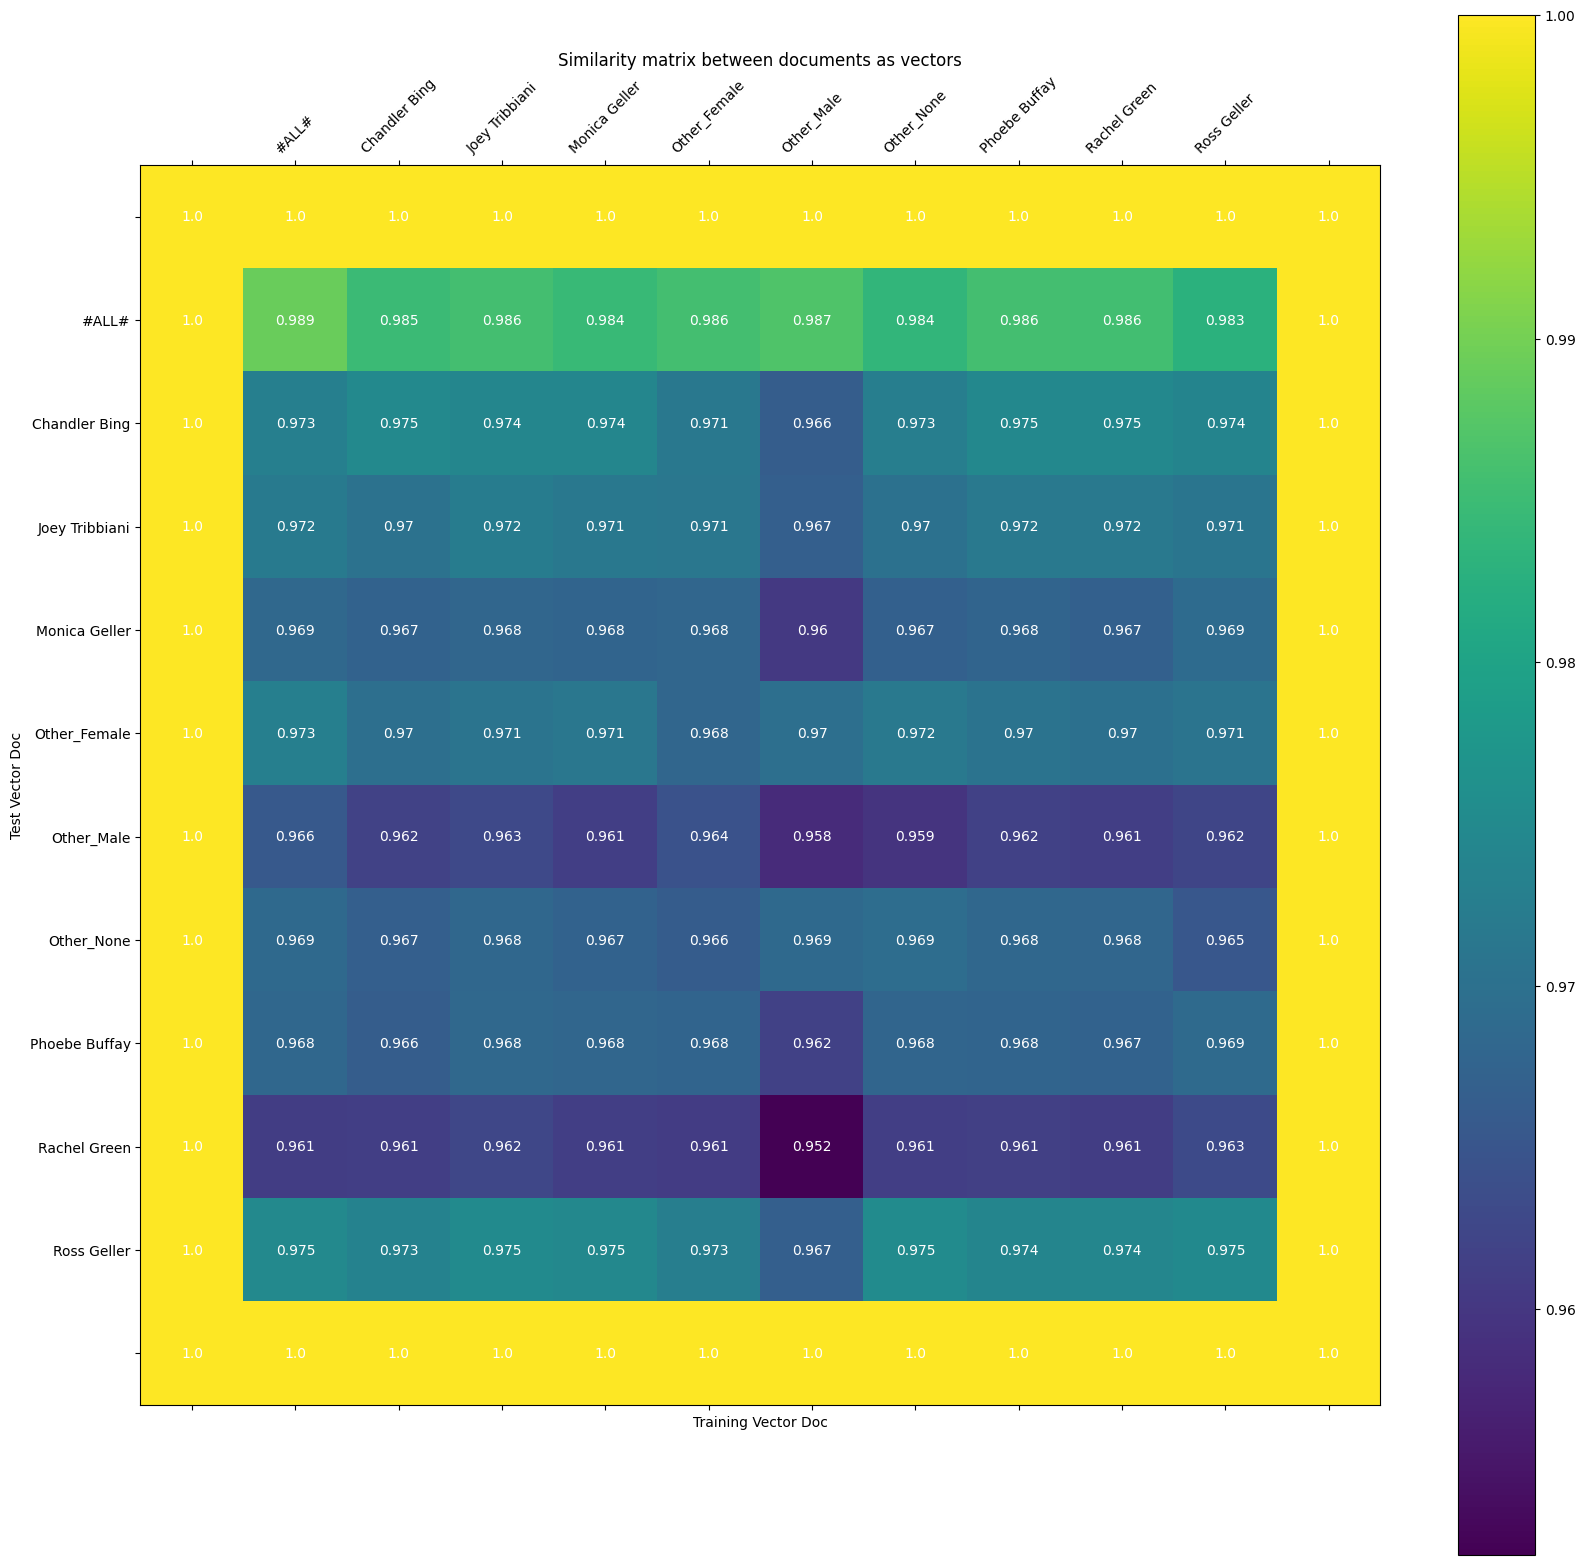

In [18]:
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the first 300 and 30 lines from the training and validation files, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **10**. Initially, the code in this template achieves a mean rank of **4.0**  and accuracy of **0.3** on the test set and a mean rank of **4.2** and accuracy of **0.1** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


In [19]:
pp_map = [
    'Basic Whitespace Tokenisation',
    'Remove stopwords and punctuation',
    'Stem of words',
    'Lemma of words',
    'Lowercasing',
    'Uppercasing',
]

mean_ranks = []
cos_sims = []
accuracies = []

pp_names = []

train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)

for i in range(6):
    pp_names.append(pp_map[i])
    
    training_corpus = [(name, pre_process(doc, i)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]
    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

    val_corpus = [(name, pre_process(doc, i)) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

    mean_rank, mean_cosine_similarity, acc, _ = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels, print_results=False)
    mean_ranks.append(mean_rank)
    cos_sims.append(mean_cosine_similarity)
    accuracies.append(acc)

data = {
    "Preprocessing Technique": pp_names,
    "Mean Rank": mean_ranks,
    "Mean Cosine Similarity": cos_sims,
    "Accuracy": accuracies,
}

pd.DataFrame(data=data)

lines per character {'Monica Geller': 302, 'Joey Tribbiani': 304, 'Chandler Bing': 300, 'Phoebe Buffay': 302, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 302, 'Other_None': 309, 'Other_Female': 304, 'Other_Male': 303}
lines per character {'Other_None': 34, 'Rachel Green': 32, 'Other_Male': 30, 'Ross Geller': 35, '#ALL#': 18, 'Phoebe Buffay': 32, 'Chandler Bing': 33, 'Monica Geller': 33, 'Joey Tribbiani': 37, 'Other_Female': 32}


,Preprocessing Technique,Mean Rank,Mean Cosine Similarity,Accuracy
0,Basic Whitespace Tokenisation,4.6,0.970354,0.4
1,Remove stopwords and punctuation,3.9,0.979640,0.3
2,Stem of words,3.8,0.978641,0.3
3,Lemma of words,3.8,0.979483,0.3
4,Lowercasing,4.1,0.970827,0.5
5,Uppercasing,4.1,0.970827,0.5


# Q2. Improve linguistic feature extraction (30 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` and `create_document_matrix_from_corpus` functions above. Examples of extra features could include extracting n-grams of different lengths and including POS tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

Matrix transformation techniques like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) are commonly used to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizer (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

Other options include using feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. 

Again, develop your system using the training and validation sets and note the effect/improvement in mean rank with the techniques you use.

In [20]:
feature_types = ["counts", "tf-idf", "n_grams", "pos"]

mean_ranks = []
cos_sims = []
accuracies = []

ft_names = []

ft_map = {
    "counts": "Simple word count",
    "tf-idf": "TF-IDF",
    "n_grams": "N-Grams",
    "pos": "POS Tagging",
}

train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)

for ft in feature_types:
    ft_names.append(ft_map[ft])
    
    training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]
    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, method=ft)

    val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, method=ft)

    mean_rank, mean_cosine_similarity, acc, _ = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels, print_results=False)
    mean_ranks.append(mean_rank)
    cos_sims.append(mean_cosine_similarity)
    accuracies.append(acc)

data = {
    "Feature Type": ft_names,
    "Mean Rank": mean_ranks,
    "Mean Cosine Similarity": cos_sims,
    "Accuracy": accuracies,
}

pd.DataFrame(data=data)

lines per character {'Monica Geller': 302, 'Joey Tribbiani': 304, 'Chandler Bing': 300, 'Phoebe Buffay': 302, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 302, 'Other_None': 309, 'Other_Female': 304, 'Other_Male': 303}
lines per character {'Other_None': 34, 'Rachel Green': 32, 'Other_Male': 30, 'Ross Geller': 35, '#ALL#': 18, 'Phoebe Buffay': 32, 'Chandler Bing': 33, 'Monica Geller': 33, 'Joey Tribbiani': 37, 'Other_Female': 32}


,Feature Type,Mean Rank,Mean Cosine Similarity,Accuracy
0,Simple word count,4.6,0.970354,0.4
1,TF-IDF,4.4,0.950503,0.4
2,N-Grams,4.8,0.531516,0.1
3,POS Tagging,5.4,0.951395,0.1


# Q3. Add dialogue context and scene features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. Only the lines from the same *Scene* can be added as the context as lines from different *Scene* are irrelevant.  **(but DO NOT USE the GENDER and CHARACTER columns directly)**.

# Q4. Parameter Search (15 marks)
It is a good practice to conduct a systematic parameter search instead of a random search as this will give you more 
reliable results. Given the scope of this assignment, it is possible to conduct a **grid search** on options you decided to try within the individual questions. The grid search should be done within the individual questions (i.e. Q1-Q3), and the later question should adopt the best settings from the previous questions. There is no need to do a grid search over all configurations from all questions as this will easily make the search unrealistic. E.g. Suppose we need 32, 90, and 4 runs to finish the grid search within questions, a cross-question grid search would need 32x90x4 = 11520 runs!                                                                      

In [21]:
pp_techniques = [0,1,2,3,4,5]
feature_types = ["counts", "tf-idf", "n_grams", "pos"]
combos = [(pp,ft) for pp in pp_techniques for ft in feature_types]

mean_ranks = []
cos_sims = []
accuracies = []

pp_names = []
ft_names = []

pp_map = [
    'Basic Whitespace Tokenisation',
    'Remove stopwords and punctuation',
    'Stem of words',
    'Lemma of words',
    'Lowercasing',
    'Uppercasing',
]

ft_map = {
    "counts": "Simple word count",
    "tf-idf": "TF-IDF",
    "n_grams": "N-Grams",
    "pos": "POS Tagging",
}

train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)

for c in combos:
    pp_names.append(pp_map[c[0]])
    ft_names.append(ft_map[c[1]])
    
    training_corpus = [(name, pre_process(doc, c[0])) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]
    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, method=c[1])

    val_corpus = [(name, pre_process(doc, c[0])) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, method=c[1])

    mean_rank, mean_cosine_similarity, acc, _ = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels, print_results=False)
    mean_ranks.append(mean_rank)
    cos_sims.append(mean_cosine_similarity)
    accuracies.append(acc)

data = {
    "Preprocessing Technique": pp_names,
    "Feature Type": ft_names,
    "Mean Rank": mean_ranks,
    "Mean Cosine Similarity": cos_sims,
    "Accuracy": accuracies,
}

pd.DataFrame(data=data)

lines per character {'Monica Geller': 302, 'Joey Tribbiani': 304, 'Chandler Bing': 300, 'Phoebe Buffay': 302, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 302, 'Other_None': 309, 'Other_Female': 304, 'Other_Male': 303}
lines per character {'Other_None': 34, 'Rachel Green': 32, 'Other_Male': 30, 'Ross Geller': 35, '#ALL#': 18, 'Phoebe Buffay': 32, 'Chandler Bing': 33, 'Monica Geller': 33, 'Joey Tribbiani': 37, 'Other_Female': 32}


,Preprocessing Technique,Feature Type,Mean Rank,Mean Cosine Similarity,Accuracy
0,Basic Whitespace Tokenisation,Simple word count,4.6,0.970354,0.4
1,Basic Whitespace Tokenisation,TF-IDF,4.4,0.950503,0.4
2,Basic Whitespace Tokenisation,N-Grams,4.8,0.531516,0.1
3,Basic Whitespace Tokenisation,POS Tagging,5.4,0.951395,0.1
4,Remove stopwords and punctuation,Simple word count,3.9,0.979640,0.3
5,Remove stopwords and punctuation,TF-IDF,4.2,0.954173,0.2
6,Remove stopwords and punctuation,N-Grams,4.9,0.539444,0.1
7,Remove stopwords and punctuation,POS Tagging,4.8,0.975152,0.2
8,Stem of words,Simple word count,3.8,0.978641,0.3
9,Stem of words,TF-IDF,4.1,0.955509,0.3


# Q5. Analyse the similarity results (10 marks)
From your system so far run on the training/validation sets, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on the training data (using the first 300 lines per character maximum) and do the final testing on the test file (using the first 30 lines per character maximum).

Make any necessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank and accuracy of document selection are on the test data.

In [25]:
# redo on training data with the first 300 character lines used

pp_method = 0 # lemma of words; best preprocessing technique
ft_method = "counts" # best feature type

train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc, pp_method)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, method=ft_method)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=30)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc, pp_method)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False, method=ft_method)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'Monica Geller': 302, 'Joey Tribbiani': 304, 'Chandler Bing': 300, 'Phoebe Buffay': 302, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 302, 'Other_None': 309, 'Other_Female': 304, 'Other_Male': 303}
Num. Characters:  10 

Monica Geller Number of Words:  14216
Joey Tribbiani Number of Words:  21267
Chandler Bing Number of Words:  15890
Phoebe Buffay Number of Words:  20247
#ALL# Number of Words:  79611
Ross Geller Number of Words:  13211
Rachel Green Number of Words:  18366
Other_None Number of Words:  14995
Other_Female Number of Words:  12825
Other_Male Number of Words:  16806
total words 227434
lines per character {'Ross Geller': 32, 'Joey Tribbiani': 33, 'Chandler Bing': 34, 'Other_Female': 31, 'Other_None': 35, '#ALL#': 12, 'Monica Geller': 30, 'Rachel Green': 33, 'Phoebe Buffay': 33, 'Other_Male': 30}
Num. Characters:  10 

Ross Geller Number of Words:  1164
Joey Tribbiani Number of Words:  1666
Chandler Bing Number of Words:  1616
Other_Female Number of W